In [2]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, HTML
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import time
import math
import re
import itertools as it

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC, LinearSVC,SVR
from sklearn.metrics import r2_score
import xgboost as xgb
from xgboost import XGBRegressor
import gc, copy
from gensim.models import Word2Vec # categorical feature to vectors
from random import shuffle
import hypertools as hyp

# Preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures
# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

#Imputation
#from fancyimpute import BiScaler, KNN

# Metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6


ecar_train = pd.read_csv('./BOT/ecar/ecar_grid_hour.csv', parse_dates=["date_time"],keep_date_col=True,index_col=['date_time'],dtype='int64')
rcar_train = pd.read_csv('./BOT/ecar/rcar_grid_hour.csv', parse_dates=["date_time"],keep_date_col=True,index_col=['date_time'],dtype='int64')
weather = pd.read_excel(u'./上海天气小时数据_201701-201703.xlsx')

display(ecar_train.info())
display(rcar_train.info())

weather = build_weather(weather)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 233241 entries, 2017-01-02 05:00:00 to 2017-03-12 23:00:00
Data columns (total 2 columns):
grid     233241 non-null int64
total    233241 non-null int64
dtypes: int64(2)
memory usage: 5.3 MB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 131491 entries, 2017-01-02 13:00:00 to 2017-03-12 21:00:00
Data columns (total 2 columns):
grid     131491 non-null int64
total    131491 non-null int64
dtypes: int64(2)
memory usage: 3.0 MB


None

,temp,humid,ludian,presure,clearance,wea_qua,wind,pub_holiday
date_time,,,,,,,,
2017-01-01 00:00:00,7.0,0.87,5.0,1028.0,8.0,6,6,1.0
2017-01-01 01:00:00,6.0,0.93,5.0,1028.0,8.0,6,6,1.0
2017-01-01 02:00:00,6.0,0.93,5.0,1028.0,8.0,6,6,1.0
2017-01-01 03:00:00,5.0,0.93,4.0,1027.0,8.0,0,0,1.0
2017-01-01 04:00:00,5.0,1.00,5.0,1027.0,7.0,0,0,1.0
2017-01-01 05:00:00,5.0,0.93,4.0,1027.0,6.0,0,0,1.0
2017-01-01 06:00:00,5.0,0.93,4.0,1027.0,5.0,9,9,1.0
2017-01-01 07:00:00,5.0,0.93,4.0,1027.0,4.0,9,9,1.0
2017-01-01 08:00:00,9.0,0.93,8.0,1027.0,7.0,0,0,1.0


In [84]:
bottest = pd.read_csv('./BOTAtest.csv')
bottest['min_lat'] = bottest['latitude_range'].map(lambda x: x.split('~')[0]).astype('float64')
bottest['max_lat'] = bottest['latitude_range'].map(lambda x: x.split('~')[1]).astype('float64')
bottest['min_lon'] = bottest['longitude_range'].map(lambda x: x.split('~')[0]).astype('float64')
bottest['max_lon'] = bottest['longitude_range'].map(lambda x: x.split('~')[1]).astype('float64')

for date in [d.strftime('%Y%m%d') for d in pd.date_range('20170102','20170312')]:
    for i in range(0,3):
        ecar = pd.read_csv('./BOT/ecar/BOT_data_ecar_%s_%s_part%d.csv' % (date,date,i))
        for index,row in bottest.iterrows():
            ecar.set_value(ecar.index[(ecar['lat']>=row['min_lat'])&(ecar['lat']<=row['max_lat'])&(ecar['lon']>=row['min_lon'])&(ecar['lon']<=row['max_lon'])].tolist(),"grid",row['grid_id'])

for date in [d.strftime('%Y%m%d') for d in pd.date_range('20170102','20170312')]:
    for i in range(0,3):
        rcar = pd.read_csv('./BOT/rcar/BOT_data_rcar_%s_%s_part%d.csv' % (date,date,i))
        for index,row in bottest.iterrows():
            rcar.set_value(rcar.index[(rcar['lat']>=row['min_lat'])&(rcar['lat']<=row['max_lat'])&(rcar['lon']>=row['min_lon'])&(rcar['lon']<=row['max_lon'])].tolist(),"grid",row['grid_id'])

KeyboardInterrupt: 

In [1]:
import lightgbm as lgb

def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

def rmse_score(predictions, targets):
    differences = predictions - targets                       #the DIFFERENCEs.
    differences_squared = differences ** 2                    #the SQUAREs of ^
    mean_of_differences_squared = differences_squared.mean()  #the MEAN of ^
    rmse_val = np.sqrt(mean_of_differences_squared)           #ROOT of ^
    
    return rmse_val

def rmse(predictions, targets):
    targets = targets.get_label()
    differences = predictions - targets                       #the DIFFERENCEs.
    differences_squared = differences ** 2                    #the SQUAREs of ^
    mean_of_differences_squared = differences_squared.mean()  #the MEAN of ^
    rmse_val = np.sqrt(mean_of_differences_squared)           #ROOT of ^
    
    return "rmse", rmse_val

def build_weather(weather):
    weather['date_time'] = pd.to_datetime(weather[u'日期'].astype('str')+' '+weather[u'时间'].astype('str'))
    weather[u'temp'] = weather[u'气温'].map(lambda x: x[:-2].strip())
    weather[u'humid'] = weather[u'湿度'].map(lambda x: x)
    weather[u'ludian'] = weather[u'露点'].map(lambda x: x[:-2].strip())
    weather[u'presure'] = weather[u'气压'].map(lambda x: x[:-2].strip())
    weather[u'clearance'] = weather[u'能见度'].map(lambda x: x[:-2].strip()).astype('str')
    weather[u'wea_qua'] = weather[u'天气状况'].map(lambda x:x)
    weather[u'wind'] = weather[u'风向'].map(lambda x:x)
    weather = weather.set_index(pd.DatetimeIndex(weather['date_time']))
    weather.drop([u'省份',u'城市',u'日期',u'时间',u'风速',u'湿度',u'瞬间风速',u'气温',u'露点',u'气压',u'能见度',u'天气状况',u'风向',u'date_time'],axis=1,inplace=True)
    
    wea_qua_le = preprocessing.LabelEncoder()
    wind_le = preprocessing.LabelEncoder()
    weather[u'wea_qua'] = wea_qua_le.fit_transform(weather[u'wea_qua'])
    weather[u'wind'] = wind_le.fit_transform(weather[u'wea_qua'])
    #weather = pd.concat([weather,pd.get_dummies(weather[u'wea_qua']),pd.get_dummies(weather[u'wind'])],axis=1)
    #weather.drop([u'wea_qua',u'wind'],axis=1,inplace=True)

    weather[u'temp'] = weather[u'temp'].astype('float64')
    weather[u'ludian'] = weather[u'ludian'].astype('float64')
    weather[u'presure'] = weather[u'presure'].astype('float64')
    weather[u'clearance'] = weather[u'clearance'].map(lambda x: np.nan if len(x)==0 else x)
    weather[u'clearance'] = weather[u'clearance'].astype('float64')
    weather[u'clearance'] = weather[u'clearance'].fillna(weather[u'clearance'].median())
    weather['pub_holiday'] = np.zeros(len(weather))
    weather.set_value('2017-01-01','pub_holiday',1)
    weather.set_value('2017-01-27','pub_holiday',1)
    weather.set_value('2017-01-28','pub_holiday',1)
    weather.set_value('2017-02-01','pub_holiday',1)
    weather.set_value('2017-02-02','pub_holiday',1)
    weather.set_value('2017-02-11','pub_holiday',1)
    weather.set_value('2017-02-14','pub_holiday',1)
    weather.set_value('2017-03-08','pub_holiday',1)
    
    return weather

def apply_w2v(sentences, model, num_features):
    def _average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        n_words = 0.
        for word in words:
            if word in vocabulary: 
                n_words = n_words + 1.
                feature_vector = np.add(feature_vector, model[word])

        if n_words:
            feature_vector = np.divide(feature_vector, n_words)
        return feature_vector
    
    vocab = set(model.wv.index2word)
    feats = [_average_word_vectors(s, model, vocab, num_features) for s in sentences]
    return np.array(feats)

def gen_cat2vec_sentences(data):
    X_w2v = copy.deepcopy(data)
    display(X_w2v)
    names = list(X_w2v.columns.values)
    for c in names:
        X_w2v[c] = X_w2v[c].fillna('unknow').astype('category')
        X_w2v[c].cat.categories = ["%s %s" % (c,g) for g in X_w2v[c].cat.categories]
    X_w2v = X_w2v.values.tolist()
    return X_w2v

def fit_cat2vec_model(daset,cat_cols):
    X_w2v = gen_cat2vec_sentences(daset.loc[:,cat_cols].sample(frac=0.6))
    for i in X_w2v:
        shuffle(i)
    model = Word2Vec(X_w2v, size=len(cat_cols), window=len(cat_cols)*2)
    return model


/Users/roy/Documents/workplace/env/lib/python2.7/site-packages/scipy/sparse/lil.py:19: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _csparsetools
/Users/roy/Documents/workplace/env/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:165: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._shortest_path import shortest_path, floyd_warshall, dijkstra,\
/Users/roy/Documents/workplace/env/lib/python2.7/site-packages/scipy/sparse/csgraph/_validation.py:5: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._tools import csgraph_to_dense, csgraph_from_dense,\
/Users/roy/Documents/workplace/env/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:167: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._traversal import breadth_first_order, dep

In [10]:
freq = '15Min'
ecar_per_hour = pd.DataFrame()
for date in [d.strftime('%Y%m%d') for d in pd.date_range('20170102','20170312')]:
    for i in range(0,3):
        ecar = pd.read_csv('./BOT/ecar/BOT_data_ecar_%s_%s_part%d_grid.csv' % (date,date,i),parse_dates=["date_time"],index_col=['date_time'])
        for name,grp in ecar.groupby('grid'):
            car_grid_per_hour = pd.concat([grp['grid'],pd.get_dummies(grp['car_id'])],axis=1).sort_index()
            car_grid_per_hour = car_grid_per_hour.drop(['grid'],axis=1).resample(freq).sum()
            for column in car_grid_per_hour.columns:
                car_grid_per_hour[column] = car_grid_per_hour[column].map(lambda x:1 if x>0 else 0)
            car_grid_per_hour['total'] = car_grid_per_hour.sum(axis=1)
            car_grid_per_hour['grid'] = name
            ecar_per_hour = pd.concat([ecar_per_hour,car_grid_per_hour[['grid','total']]])

            
rcar_per_hour = pd.DataFrame()
for date in [d.strftime('%Y%m%d') for d in pd.date_range('20170102','20170312')]:
    for i in range(0,3):
        rcar = pd.read_csv('./BOT/rcar/BOT_data_rcar_%s_%s_part%d_grid.csv' % (date,date,i),parse_dates=["date_time"],index_col=['date_time'])
        for name,grp in rcar.groupby('grid'):
            car_grid_per_hour = pd.concat([grp['grid'],pd.get_dummies(grp['car_id'])],axis=1).sort_index()
            car_grid_per_hour = car_grid_per_hour.drop(['grid'],axis=1).resample(freq).sum()
            for column in car_grid_per_hour.columns:
                car_grid_per_hour[column] = car_grid_per_hour[column].map(lambda x:1 if x>0 else 0)
            car_grid_per_hour['total'] = car_grid_per_hour.sum(axis=1)
            car_grid_per_hour['grid'] = name
            rcar_per_hour = pd.concat([rcar_per_hour,car_grid_per_hour[['grid','total']]])

ecar_per_hour.to_csv('./BOT/ecar_grid_hour_groupby_%s.csv' % freq)
rcar_per_hour.to_csv('./BOT/rcar_grid_hour_groupby_%s.csv' % freq)

e = ecar_per_hour.groupby(['date_time','grid']).sum().sort_index().reset_index()
r = rcar_per_hour.groupby(['date_time','grid']).sum().sort_index().reset_index()

In [111]:
ecar_per_hour.to_csv('./BOT/ecar_grid_hour_groupby_5min.csv')
rcar_per_hour.to_csv('./BOT/rcar_grid_hour_groupby_5min.csv')

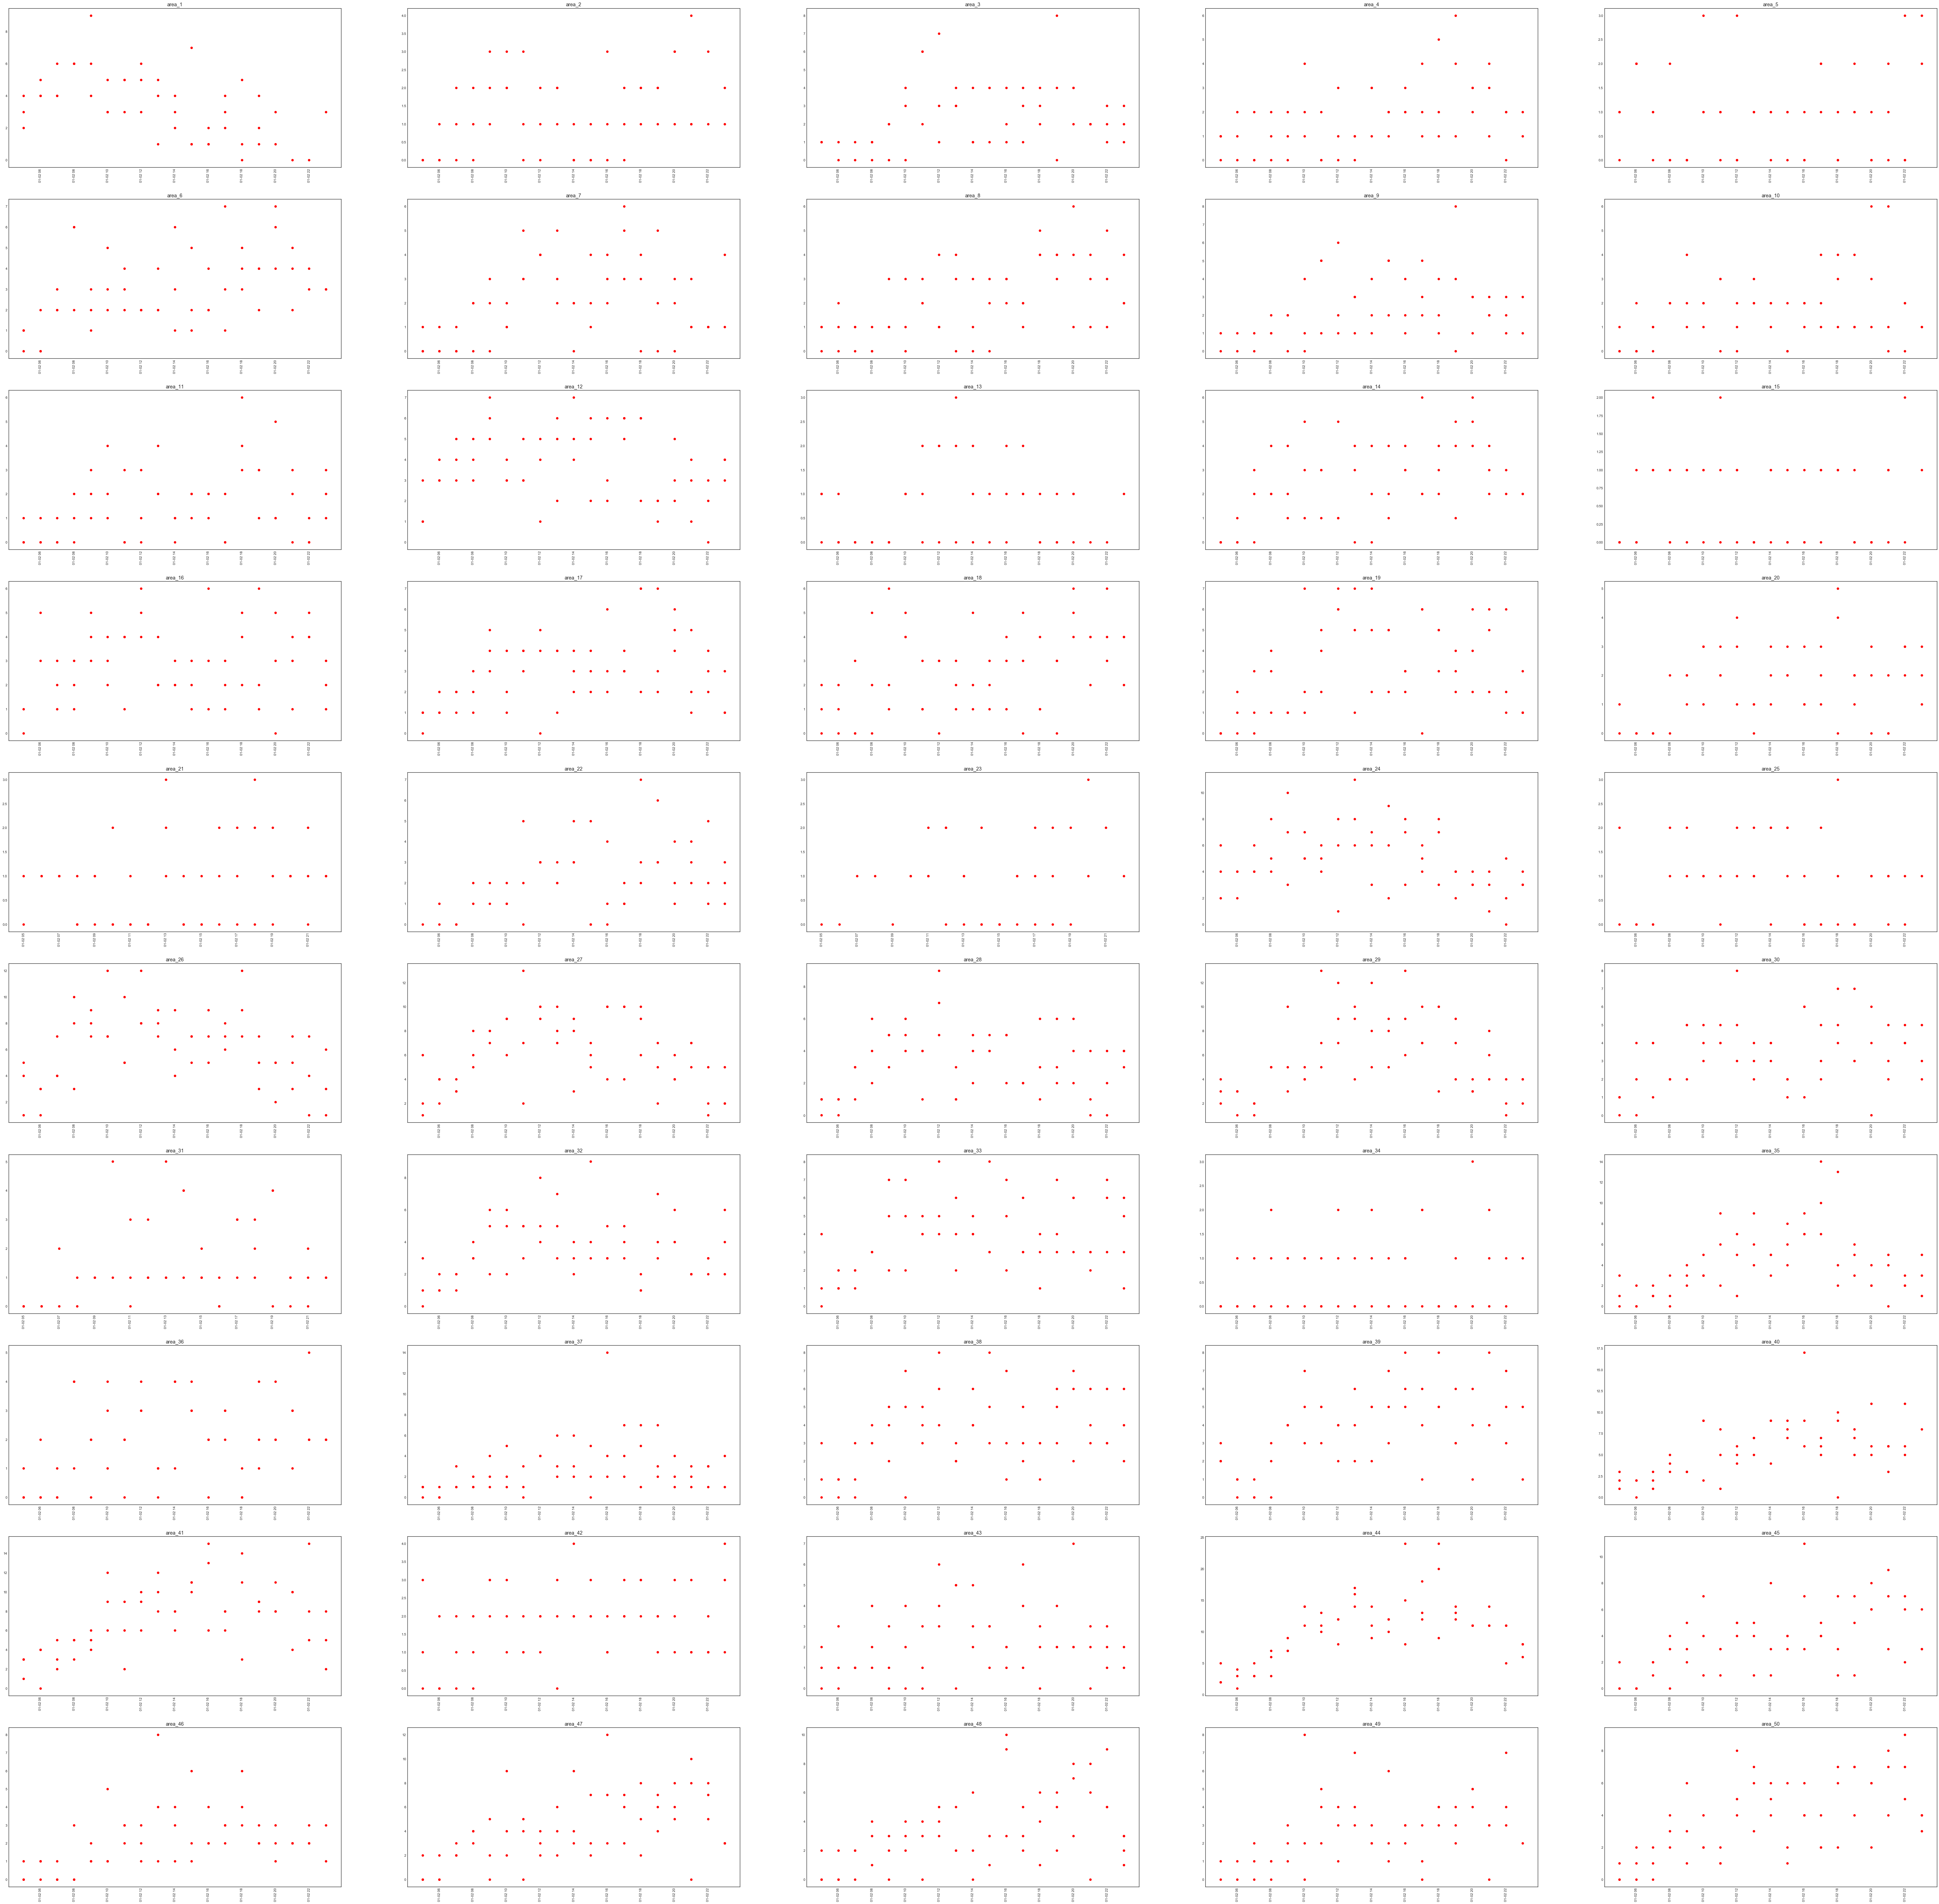

In [17]:
#plt.plot(ecar_train['grid'], ecar_train['total'], 'ro')
#plt.axis([0, 6, 0, 20])
#plt.show()



grps = ecar_train.groupby('grid')
f,ax = plt.subplots(10,5,figsize=(100,100))
ax = ax.ravel()
i=0
for name,grp in grps:
    ax[i].plot(grp.loc['2017-01-02 05:00':'2017-01-02 23:00']['total'],'ro')
    ax[i].set_title('area_%s' % name)
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(90)
    i+=1
    
grps = rcar_train.groupby('grid')
f,ax = plt.subplots(10,5,figsize=(100,100))
ax = ax.ravel()
i=0
for name,grp in grps:
    ax[i].plot(grp.loc['2017-01-02 05:00':'2017-01-02 23:00']['total'],'ro')
    ax[i].set_title('area_%s' % name)
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(90)
    i+=1

In [3]:
ecar_per_hour = pd.read_csv('./BOT/ecar_grid_hour_groupby_5min.csv',parse_dates=['date_time'],index_col=['date_time'])
e = ecar_per_hour.groupby(['date_time','grid']).sum().sort_index().reset_index()

rcar_per_hour = pd.read_csv('./BOT/rcar_grid_hour_groupby_5min.csv',parse_dates=['date_time'],index_col=['date_time'])
r = rcar_per_hour.groupby(['date_time','grid']).sum().sort_index().reset_index()

#tup = [[x for x in pd.date_range(start='2017-01-01 18:00:00', end='2017-03-12 23:00:00',freq='H')],range(1,51)]
#tups = list(it.product(*tup))
#car_per_hour_def_index = pd.MultiIndex.from_tuples((tups), names=['date_time', 'grid'])
#car_per_hour_def = pd.DataFrame(np.zeros(len((tups))), index=car_per_hour_def_index,columns=['total'])
#car_per_hour_def_flat = car_per_hour_def.reset_index()
#car_per_hour_def_flat = pd.merge(car_per_hour_def_flat,e,on=['date_time','grid'],how='left')
#car_per_hour_def_flat = pd.merge(car_per_hour_def_flat,r,on=['date_time','grid'],how='left')

,date_time,grid,total
0,2017-01-01 18:35:00,42.0,1
1,2017-01-01 18:40:00,42.0,1
2,2017-01-01 18:45:00,42.0,0
3,2017-01-01 18:50:00,42.0,0
4,2017-01-01 18:55:00,42.0,0
5,2017-01-01 19:00:00,42.0,0
6,2017-01-01 19:05:00,42.0,0
7,2017-01-01 19:10:00,42.0,0
8,2017-01-01 19:15:00,42.0,0
9,2017-01-01 19:20:00,42.0,0


In [27]:
cat_cols = ['grid', 'clearance', 'wea_qua','wind','pub_holiday', 'isweekend']
y = e.total
ete = pd.read_csv('./test.csv',parse_dates=['date_time'])
tr_index = e.index
ete_index = ete.index
edaset = pd.concat([train_data,ete],axis=0)
edaset = pd.merge(edaset.set_index('date_time'),weather,how='inner',left_index=True,right_index=True)
edaset = edaset.reset_index()
edaset = build_features(edaset)

display(len(gen_cat2vec_sentences(edaset.loc[tr_index,cat_cols])))
#c2v_model = fit_cat2vec_model(edaset,cat_cols)
#display(c2v_model)
#c2v_model = fit_cat2vec_model(edaset,cat_cols)
#etr_c2v_matrix = apply_w2v(gen_cat2vec_sentences(edaset.loc[tr_index,cat_cols]), c2v_model, len(cat_cols))

82504

In [113]:
merge_train=pd.merge(e,r,on=['date_time','grid'],how='left')
merge_train=merge_train.fillna(0)
merge_train['total'] = merge_train.apply(lambda x: x[['total_x','total_y']].sum(),axis=1)
display(merge_train)

KeyboardInterrupt: 

In [84]:
car_per_hour_def_flat['total'] = car_per_hour_def_flat.fillna(0).apply(lambda x: (x['total']+x['total_x']+x['total_y']),axis=1)
car_per_hour_pure = car_per_hour_def_flat.drop(['total_x','total_y'],axis=1)

car_per_hour_pure[['grid','total']] = car_per_hour_pure[['grid','total']].astype('int64')
display(car_per_hour_pure.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84300 entries, 0 to 84299
Data columns (total 3 columns):
date_time    84300 non-null datetime64[ns]
grid         84300 non-null int64
total        84300 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 2.6 MB


None

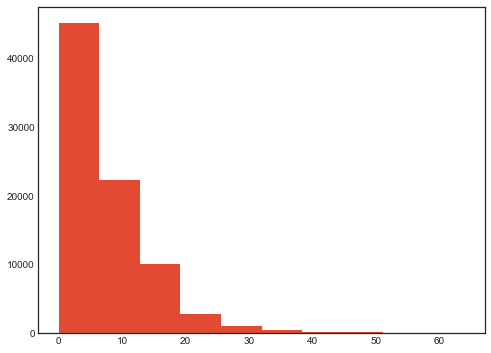

,grid,total
count,82504.000000,82504.000000
mean,25.629715,7.485189
std,14.421665,7.098414
min,1.000000,0.000000
25%,13.000000,2.000000
50%,26.000000,6.000000
75%,38.000000,11.000000
max,50.000000,64.000000


In [20]:

plt.hist(e['total'])
plt.show()

display(e.describe())

Daset shape rows:93004 cols:3
apply_w2v for cat2vec
(93004, 5)


In [302]:
def build_features(features):
    #features['Month'] = features['date_time'].map(lambda x: x.month)
    #features['Year'] = features['date_time'].map(lambda x: x.year)
    features['Week'] = features['date_time'].map(lambda x: x.strftime("%V"))
    features['Week']= pd.to_numeric(features['Week'], downcast='integer')
    #features['Season'] = features['date_time'].map(lambda x: 1 if x.month in [1,2,3] else (2 if x.month in [4,5,6] else (3 if x.month in [7,8,9] else 4)))
    features['WeekOfYear'] = features['date_time'].map(lambda x: x.isocalendar()[1]).astype(float)
    features['DayOfYear'] = features['date_time'].map(lambda x: x.timetuple().tm_yday).astype(float)
    #features['Hour'] = features['date_time'].map(lambda x: x.hour)
    features['Minute'] = features['date_time'].map(lambda x: x.minute)
    features['DayOfWeek'] = features['date_time'].map(lambda x: x.dayofweek)
    features['isweekend'] = features.apply(lambda x:1 if x['DayOfWeek']>5 else 0,axis=1)
    
    return features.drop(['date_time'],axis=1)


from datetime import datetime
test_start_date = '2017-02-13 00:00:00'
test_start_date = datetime.strptime(test_start_date,'%Y-%m-%d %H:%M:%S')

train_data = e[e.date_time<test_start_date]
test_data = e[e.date_time>=test_start_date]

#train_data = pd.merge(train_data.set_index('date_time').sort_index(),(weather),how='inner',left_index=True,right_index=True)
#test_data = pd.merge(test_data.set_index('date_time').sort_index(),(weather),how='inner',left_index=True,right_index=True)

#train_data = train_data.reset_index()
#test_data = test_data.reset_index()

#train_data = build_features(train_data)
#test_data = build_features(test_data)

dtrain = xgb.DMatrix(train_data.drop(['total'],axis=1), np.log1p(train_data[['total']]))
dvalid = xgb.DMatrix(test_data.drop(['total'],axis=1), np.log1p(test_data[['total']]))
watchlist = [(dtrain, 'train'),(dvalid, 'eval')]
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.8,
          "max_depth": 8,
          "subsample": 0.4,
          "colsample_bytree": 0.6,
          "min_child_weight":8,
          "reg_alpha":1e-05,
          "seed":31,
          "silent": 1
          }
num_trees = 3000
res = {}
egbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=300, feval=rmse, verbose_eval=300,evals_result=res)

print("Validating")
display(train_data.drop(['total'],axis=1).head())
display(test_data.drop(['total'],axis=1).head())
train_probs = gbm.predict(xgb.DMatrix(test_data.drop(['total'],axis=1)))
error = rmse_score(train_probs, np.log1p(test_data[['total']]))
print('error', error)
print('scroe',1.0/(1.0+error))

[0]	train-rmse:0.738831	eval-rmse:1.02446	train-rmse:0.738831	eval-rmse:1.02446
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 300 rounds.
[300]	train-rmse:0.397716	eval-rmse:1.26244	train-rmse:0.397716	eval-rmse:1.26244
Stopping. Best iteration:
[2]	train-rmse:0.546191	eval-rmse:0.840819	train-rmse:0.546191	eval-rmse:0.840819

Validating


,grid,temp,humid,ludian,presure,clearance,wea_qua,wind,pub_holiday,Week,WeekOfYear,DayOfYear,Minute,DayOfWeek,isweekend
0,42.0,13.0,0.77,9.0,1022.0,8.0,6,6,1.0,52,52.0,1.0,0,6,1
1,42.0,12.0,0.82,9.0,1023.0,8.0,6,6,1.0,52,52.0,1.0,0,6,1
2,42.0,11.0,0.88,9.0,1022.0,8.0,6,6,1.0,52,52.0,1.0,0,6,1
3,42.0,12.0,0.82,9.0,1023.0,8.0,6,6,1.0,52,52.0,1.0,0,6,1
4,19.0,12.0,0.88,10.0,1022.0,8.0,6,6,1.0,52,52.0,1.0,0,6,1


,grid,temp,humid,ludian,presure,clearance,wea_qua,wind,pub_holiday,Week,WeekOfYear,DayOfYear,Minute,DayOfWeek,isweekend
0,1.0,5.0,0.61,-2.0,1031.0,8.0,6,6,0.0,7,7.0,44.0,0,0,0
1,3.0,5.0,0.61,-2.0,1031.0,8.0,6,6,0.0,7,7.0,44.0,0,0,0
2,4.0,5.0,0.61,-2.0,1031.0,8.0,6,6,0.0,7,7.0,44.0,0,0,0
3,5.0,5.0,0.61,-2.0,1031.0,8.0,6,6,0.0,7,7.0,44.0,0,0,0
4,6.0,5.0,0.61,-2.0,1031.0,8.0,6,6,0.0,7,7.0,44.0,0,0,0


ValueError: feature_names mismatch: [u'grid', u'Week', u'WeekOfYear', u'DayOfYear', u'Minute', u'DayOfWeek', u'isweekend'] [u'grid', u'temp', u'humid', u'ludian', u'presure', u'clearance', u'wea_qua', u'wind', u'pub_holiday', u'Week', u'WeekOfYear', u'DayOfYear', u'Minute', u'DayOfWeek', u'isweekend']
training data did not have the following fields: humid, temp, ludian, wea_qua, presure, clearance, wind, pub_holiday

In [143]:
def build_features(features):
    #features['Month'] = features['date_time'].map(lambda x: x.month)
    #features['Year'] = features['date_time'].map(lambda x: x.year)
    features['Week'] = features['date_time'].map(lambda x: x.strftime("%V"))
    features['Week']= pd.to_numeric(features['Week'], downcast='integer')
    #features['Season'] = features['date_time'].map(lambda x: 1 if x.month in [1,2,3] else (2 if x.month in [4,5,6] else (3 if x.month in [7,8,9] else 4)))
    features['WeekOfYear'] = features['date_time'].map(lambda x: x.isocalendar()[1]).astype(float)
    features['DayOfYear'] = features['date_time'].map(lambda x: x.timetuple().tm_yday).astype(float)
    #features['Hour'] = features['date_time'].map(lambda x: x.hour)
    features['Minute'] = features['date_time'].map(lambda x: x.minute)
    features['DayOfWeek'] = features['date_time'].map(lambda x: x.dayofweek)
    features['isweekend'] = features.apply(lambda x:1 if x['DayOfWeek']>5 else 0,axis=1)
    
    display(features.columns)
    return features.drop(['date_time'],axis=1)


from datetime import datetime
test_start_date = '2017-02-13 00:00:00'
test_start_date = datetime.strptime(test_start_date,'%Y-%m-%d %H:%M:%S')

train_data = r[r.date_time<test_start_date]
test_data = r[r.date_time>=test_start_date]

train_data = build_features(train_data[['date_time','grid','total']])
test_data = build_features(test_data[['date_time','grid','total']])


dtrain = xgb.DMatrix(train_data.drop(['total'],axis=1), np.log1p(train_data[['total']]))
dvalid = xgb.DMatrix(test_data.drop(['total'],axis=1), np.log1p(test_data[['total']]))
watchlist = [(dtrain, 'train'),(dvalid, 'eval')]
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.01,
          "max_depth": 8,
          "subsample": 0.4,
          "colsample_bytree": 0.9,
          "min_child_weight":8,
          "reg_alpha":1e-03,
          "seed":31,
          "silent": 1
          }
num_trees = 30000
res = {}
rgbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=100, feval=rmse, verbose_eval=300,evals_result=res)

print("Validating")
train_probs = gbm.predict(xgb.DMatrix(test_data.drop(['total'],axis=1)))
error = rmse_score(train_probs, np.log1p(test_data[['total']].values.ravel()))
print('error', error)
print('scroe',1.0/(1.0+error))

Index([u'date_time', u'grid', u'total', u'Week', u'WeekOfYear', u'DayOfYear',
       u'Minute', u'DayOfWeek', u'isweekend'],
      dtype='object')

Index([u'date_time', u'grid', u'total', u'Week', u'WeekOfYear', u'DayOfYear',
       u'Minute', u'DayOfWeek', u'isweekend'],
      dtype='object')

[0]	train-rmse:0.600977	eval-rmse:0.638796	train-rmse:0.600977	eval-rmse:0.638796
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[300]	train-rmse:0.519284	eval-rmse:0.546103	train-rmse:0.519284	eval-rmse:0.546103
Stopping. Best iteration:
[480]	train-rmse:0.514675	eval-rmse:0.543707	train-rmse:0.514675	eval-rmse:0.543707

Validating
('error', 1.2996067215822331)
('scroe', 0.43485696515617894)


Index([u'date_time', u'grid', u'Week', u'WeekOfYear', u'DayOfYear', u'Minute',
       u'DayOfWeek', u'isweekend'],
      dtype='object')

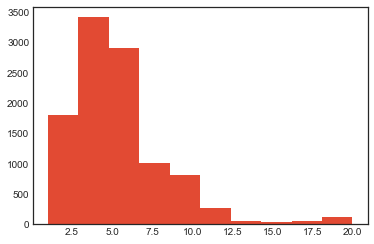

In [155]:
import datetime
tup = [[x for x in pd.date_range(start='2017-03-13 06:00',end='2017-03-26 23:00',freq='H')],range(1,51)]
tups = list(it.product(*tup))
index = pd.MultiIndex.from_tuples((tups), names=['date_time', 'grid'])
test_set = pd.DataFrame(np.zeros(len(tups)),index=index,columns=['total'])
test_set = test_set.reset_index().set_index('date_time').sort_index()
test_set = test_set.between_time('8:00', '22:00')
test_set = test_set.reset_index()
test_probs = egbm.predict(xgb.DMatrix(build_features(test_set.drop(['total'],axis=1))))
submit = pd.DataFrame({'grid_id':test_set['grid'],'day':test_set['date_time'].map(lambda x: x.strftime('%Y%m%d')),'hour':test_set['date_time'].map(lambda x: x.strftime('%H')),'car_number':np.around(np.expm1(test_probs))})
column_titles = ['grid_id','day','hour','car_number']
submit = submit.reindex(columns=column_titles)
submit['hour'] = submit['hour'].map(lambda x:int(x)+1)
submit['car_number'] = submit['car_number'].astype('int64')
today = datetime.datetime.today().strftime("%Y%m%d%H%M")
submit.to_csv('submissions_%s_e.csv' % today,index=False)

plt.hist(submit['car_number'])
plt.show()

Index([u'date_time', u'grid', u'Week', u'WeekOfYear', u'DayOfYear', u'Minute',
       u'DayOfWeek', u'isweekend'],
      dtype='object')

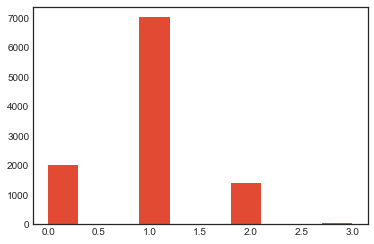

In [156]:
import datetime
tup = [[x for x in pd.date_range(start='2017-03-13 06:00',end='2017-03-26 23:00',freq='H')],range(1,51)]
tups = list(it.product(*tup))
index = pd.MultiIndex.from_tuples((tups), names=['date_time', 'grid'])
test_set = pd.DataFrame(np.zeros(len(tups)),index=index,columns=['total'])
test_set = test_set.reset_index().set_index('date_time').sort_index()
test_set = test_set.between_time('8:00', '22:00')
test_set = test_set.reset_index()
test_probs = rgbm.predict(xgb.DMatrix(build_features(test_set.drop(['total'],axis=1))))
submit = pd.DataFrame({'grid_id':test_set['grid'],'day':test_set['date_time'].map(lambda x: x.strftime('%Y%m%d')),'hour':test_set['date_time'].map(lambda x: x.strftime('%H')),'car_number':np.around(np.expm1(test_probs))})
column_titles = ['grid_id','day','hour','car_number']
submit = submit.reindex(columns=column_titles)
submit['hour'] = submit['hour'].map(lambda x:int(x)+1)
submit['car_number'] = submit['car_number'].astype('int64')

today = datetime.datetime.today().strftime("%Y%m%d%H%M")
submit.to_csv('submissions_%s_r.csv' % today,index=False)

plt.hist(submit['car_number'])
plt.show()

In [81]:
from sklearn.preprocessing import StandardScaler

def build_features(features):
    features['Day'] = features['date_time'].map(lambda x: x.day)
    features['Month'] = features['date_time'].map(lambda x: x.month)
    #features['Year'] = features['date_time'].map(lambda x: x.year)
    features['Week'] = features['date_time'].map(lambda x: x.strftime("%V"))
    features['Week']= pd.to_numeric(features['Week'], downcast='integer')
    #features['Season'] = features['date_time'].map(lambda x: 1 if x.month in [1,2,3] else (2 if x.month in [4,5,6] else (3 if x.month in [7,8,9] else 4)))
    features['WeekOfYear'] = features['date_time'].map(lambda x: x.isocalendar()[1]).astype(float)
    features['DayOfYear'] = features['date_time'].map(lambda x: x.timetuple().tm_yday).astype(float)
    features['Hour'] = features['date_time'].map(lambda x: x.hour)
    features['Minute'] = features['date_time'].map(lambda x: x.minute)
    features['DayOfWeek'] = features['date_time'].map(lambda x: x.dayofweek)
    features['isweekend'] = features.apply(lambda x:1 if x['DayOfWeek']>5 else 0,axis=1)
    features['Minute'] = features['date_time'].map(lambda x: x.minute)
    features = features.drop(['date_time'],axis=1)
    
    #features = StandardScaler().fit_transform(features)

    return features


    
from datetime import datetime
test_start_date = '2017-02-13 00:00:00'
test_start_date = datetime.strptime(test_start_date,'%Y-%m-%d %H:%M:%S')

train_data = e[e.date_time<test_start_date]
test_data = e[e.date_time>=test_start_date]

#train_data = train_data.set_index('date_time').sort_index()
#test_data = test_data.set_index('date_time').sort_index()
#cat_cols = ['grid', 'clearance', 'wea_qua','wind','pub_holiday', 'isweekend']
#ete = pd.read_csv('./test.csv',parse_dates=['date_time'],index_col=['date_time'])
#display(len(ete))
#train_data_w = pd.merge(train_data,weather,how='inner',left_index=True,right_index=True)
#test_data_w = pd.merge(test_data,weather,how='inner',left_index=True,right_index=True)
#ete_w = pd.merge(ete,weather,how='inner',left_index=True,right_index=True)
#train_data = train_data.reset_index()
#test_data = test_data.reset_index()
#tr_index = train_data_w.index
#va_index = test_data_w.index
#ete_index = ete.index
#edaset = pd.concat([train_data_w,test_data_w,ete_w],axis=0)
#rdaset = pd.merge(rdaset,weather,how='inner',left_index=True,right_index=True)
#edaset = edaset.reset_index()
#edaset = build_features(edaset)
#edaset = edaset.set_index('date_time').sort_index()

#c2v_model = fit_cat2vec_model(edaset,cat_cols)
#etr_c2v_matrix = apply_w2v(gen_cat2vec_sentences(edaset.loc[tr_index,cat_cols]), c2v_model, len(cat_cols))
#eva_c2v_matrix = apply_w2v(gen_cat2vec_sentences(edaset.loc[va_index,cat_cols]), c2v_model, len(cat_cols))
#ete_c2v_matrix = apply_w2v(gen_cat2vec_sentences(edaset.loc[ete_index,cat_cols]), c2v_model, len(cat_cols))


weather = weather.resample(freq).fillna('nearest')
train_data = pd.merge(train_data.set_index('date_time').sort_index(),(weather),how='inner',left_index=True,right_index=True)
test_data = pd.merge(test_data.set_index('date_time').sort_index(),(weather),how='inner',left_index=True,right_index=True)

train_data = train_data.reset_index()
test_data = test_data.reset_index()



#etr_c2v_df = pd.DataFrame(etr_c2v_matrix)
#eva_c2v_df = pd.DataFrame(eva_c2v_matrix)
#ete_c2v_df = pd.DataFrame(ete_c2v_matrix)

#train_set = edaset.loc[tr_index,:].reset_index().drop(['total','date_time']+cat_cols,axis=1)
#va_set = edaset.loc[va_index,:].reset_index().drop(['total','date_time']+cat_cols,axis=1)
#dtrain = lgb.Dataset(pd.concat([train_set,(etr_c2v_df)],axis=1,ignore_index=True), (edaset.loc[tr_index,'total'].values.ravel()))
#dvalid = lgb.Dataset(pd.concat([va_set,(eva_c2v_df)],axis=1,ignore_index=True), (edaset.loc[va_index,'total'].values.ravel()))

X_train,y_train = train_data.drop(['total'],axis=1),train_data[['total']].values.ravel()
X_test,y_test = test_data.drop(['total'],axis=1),test_data[['total']].values.ravel()

X_train = build_features(X_train)
X_test = build_features(X_test)

dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_test, y_test)


parameters = {
'objective': 'regression_l2',
'metric': 'l2_root',
'boosting': 'gbdt',
'num_leaves': 31,
'bagging_fraction': 0.5,
'bagging_freq': 30,
'learning_rate': 0.01
}

num_trees = 60000

res = {}

egbm = lgb.train(parameters,
                   dtrain,
                   valid_sets=dvalid,
                   num_boost_round=num_trees,
                   early_stopping_rounds=300,verbose_eval=600)

print("Validating")
train_probs = egbm.predict(X_test)
error = rmse_score(train_probs, y_test)
print('error', error)
print('scroe',1.0/(1.0+error))

Training until validation scores don't improve for 300 rounds.
[600]	valid_0's rmse: 1.79044
Early stopping, best iteration is:
[804]	valid_0's rmse: 1.77939
Validating
('error', 1.7793886738459652)
('scroe', 0.35979134887106484)


In [83]:
from sklearn.preprocessing import StandardScaler

def build_features(features):
    features['Day'] = features['date_time'].map(lambda x: x.day)
    features['Month'] = features['date_time'].map(lambda x: x.month)
    #features['Year'] = features['date_time'].map(lambda x: x.year)
    features['Week'] = features['date_time'].map(lambda x: x.strftime("%V"))
    features['Week']= pd.to_numeric(features['Week'], downcast='integer')
    #features['Season'] = features['date_time'].map(lambda x: 1 if x.month in [1,2,3] else (2 if x.month in [4,5,6] else (3 if x.month in [7,8,9] else 4)))
    features['WeekOfYear'] = features['date_time'].map(lambda x: x.isocalendar()[1]).astype(float)
    features['DayOfYear'] = features['date_time'].map(lambda x: x.timetuple().tm_yday).astype(float)
    features['Hour'] = features['date_time'].map(lambda x: x.hour)
    features['Minute'] = features['date_time'].map(lambda x: x.minute)
    features['DayOfWeek'] = features['date_time'].map(lambda x: x.dayofweek)
    features['isweekend'] = features.apply(lambda x:1 if x['DayOfWeek']>5 else 0,axis=1)
    features['Minute'] = features['date_time'].map(lambda x: x.minute)
    features = features.drop(['date_time'],axis=1)
    
    #features = StandardScaler().fit_transform(features)

    return features


    
from datetime import datetime
test_start_date = '2017-02-13 00:00:00'
test_start_date = datetime.strptime(test_start_date,'%Y-%m-%d %H:%M:%S')

train_data = r[r.date_time<test_start_date]
test_data = r[r.date_time>=test_start_date]

#train_data = train_data.set_index('date_time').sort_index()
#test_data = test_data.set_index('date_time').sort_index()
#cat_cols = ['grid', 'clearance', 'wea_qua','wind','pub_holiday', 'isweekend']
#ete = pd.read_csv('./test.csv',parse_dates=['date_time'],index_col=['date_time'])
#display(len(ete))
#train_data_w = pd.merge(train_data,weather,how='inner',left_index=True,right_index=True)
#test_data_w = pd.merge(test_data,weather,how='inner',left_index=True,right_index=True)
#ete_w = pd.merge(ete,weather,how='inner',left_index=True,right_index=True)
#train_data = train_data.reset_index()
#test_data = test_data.reset_index()
#tr_index = train_data_w.index
#va_index = test_data_w.index
#ete_index = ete.index
#edaset = pd.concat([train_data_w,test_data_w,ete_w],axis=0)
#rdaset = pd.merge(rdaset,weather,how='inner',left_index=True,right_index=True)
#edaset = edaset.reset_index()
#edaset = build_features(edaset)
#edaset = edaset.set_index('date_time').sort_index()

#c2v_model = fit_cat2vec_model(edaset,cat_cols)
#etr_c2v_matrix = apply_w2v(gen_cat2vec_sentences(edaset.loc[tr_index,cat_cols]), c2v_model, len(cat_cols))
#eva_c2v_matrix = apply_w2v(gen_cat2vec_sentences(edaset.loc[va_index,cat_cols]), c2v_model, len(cat_cols))
#ete_c2v_matrix = apply_w2v(gen_cat2vec_sentences(edaset.loc[ete_index,cat_cols]), c2v_model, len(cat_cols))


weather = weather.resample(freq).fillna('nearest')
train_data = pd.merge(train_data.set_index('date_time').sort_index(),(weather),how='inner',left_index=True,right_index=True)
test_data = pd.merge(test_data.set_index('date_time').sort_index(),(weather),how='inner',left_index=True,right_index=True)

train_data = train_data.reset_index()
test_data = test_data.reset_index()



#etr_c2v_df = pd.DataFrame(etr_c2v_matrix)
#eva_c2v_df = pd.DataFrame(eva_c2v_matrix)
#ete_c2v_df = pd.DataFrame(ete_c2v_matrix)

#train_set = edaset.loc[tr_index,:].reset_index().drop(['total','date_time']+cat_cols,axis=1)
#va_set = edaset.loc[va_index,:].reset_index().drop(['total','date_time']+cat_cols,axis=1)
#dtrain = lgb.Dataset(pd.concat([train_set,(etr_c2v_df)],axis=1,ignore_index=True), (edaset.loc[tr_index,'total'].values.ravel()))
#dvalid = lgb.Dataset(pd.concat([va_set,(eva_c2v_df)],axis=1,ignore_index=True), (edaset.loc[va_index,'total'].values.ravel()))

X_train,y_train = train_data.drop(['total'],axis=1),train_data[['total']].values.ravel()
X_test,y_test = test_data.drop(['total'],axis=1),test_data[['total']].values.ravel()

X_train = build_features(X_train)
X_test = build_features(X_test)

dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_test, y_test)


parameters = {
'objective': 'regression_l2',
'metric': 'l2_root',
'boosting': 'gbdt',
'num_leaves': 31,
'bagging_fraction': 0.5,
'bagging_freq': 30,
'learning_rate': 0.01
}

num_trees = 60000

res = {}

rgbm = lgb.train(parameters,
                   dtrain,
                   valid_sets=dvalid,
                   num_boost_round=num_trees,
                   early_stopping_rounds=300,verbose_eval=600)

print("Validating")
train_probs = rgbm.predict(X_test)
error = rmse_score(train_probs, y_test)
print('error', error)
print('scroe',1.0/(1.0+error))

Training until validation scores don't improve for 300 rounds.
[600]	valid_0's rmse: 0.654539
[1200]	valid_0's rmse: 0.654354
Early stopping, best iteration is:
[1073]	valid_0's rmse: 0.653814
Validating
('error', 0.6538142110376621)
('scroe', 0.60466284140379)


,grid_id,hour,car_number
count,9800.000000,9800.000000,9800.000000
mean,25.500000,15.500000,9.952959
std,14.431606,4.031335,6.810958
min,1.000000,9.000000,0.000000
25%,13.000000,12.000000,6.000000
50%,25.500000,15.500000,9.000000
75%,38.000000,19.000000,12.000000
max,50.000000,22.000000,50.000000


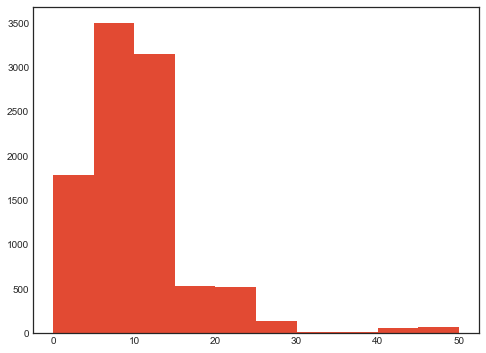

In [65]:
import datetime
tup = [[x for x in pd.date_range(start='2017-03-13 06:00',end='2017-03-26 23:00',freq=freq)],range(1,51)]
tups = list(it.product(*tup))
index = pd.MultiIndex.from_tuples((tups), names=['date_time', 'grid'])
test_set = pd.DataFrame(np.zeros(len(tups)),index=index,columns=['total'])
test_set = test_set.reset_index().set_index('date_time').sort_index()
test_set = test_set.between_time('9:00', '22:00')
weather = weather.resample(freq).fillna('nearest')
test_set = pd.merge(test_set,weather,left_index=True,right_index=True)
test_set = test_set.reset_index()
test_probs = egbm.predict((build_features(test_set.drop(['total'],axis=1))))
submit = pd.DataFrame({'grid_id':test_set['grid'],'date_time':test_set['date_time'],'car_number':((test_probs))}).set_index(['date_time'])
car_grid_per_hour_aggr = pd.DataFrame()
for name,grp in submit.groupby('grid_id'):
    car_grid_per_hour = grp.sort_index()
    car_grid_per_hour['car_number'] = np.around(car_grid_per_hour.drop(['grid_id'],axis=1).resample('H').sum())
    car_grid_per_hour['grid_id'] = name
    car_grid_per_hour_aggr = pd.concat([car_grid_per_hour_aggr,car_grid_per_hour.dropna()],axis=0)

submitssion = pd.DataFrame()
for name,gp in car_grid_per_hour_aggr.reset_index().sort_values(by=['date_time','grid_id']).groupby('date_time'):
    submitssion = pd.concat([submitssion,gp])
    

submitssion['day'] = submitssion['date_time'].map(lambda x: x.strftime('%Y%m%d'))
submitssion['hour'] = submitssion['date_time'].map(lambda x: x.strftime('%H')).astype('int32')
submitssion['car_number'] = submitssion['car_number'].astype('int32')
column_titles = ['grid_id','day','hour','car_number']
submitssion = submitssion.reindex(columns=column_titles)
display(submitssion.describe())

plt.hist(submitssion['car_number'])
plt.show()

today = datetime.datetime.today().strftime("%Y%m%d%H%M")
submitssion.to_csv('submissions_%s_e.csv' % today,index=False)

#submit = pd.DataFrame({'grid_id':test_set['grid'],'day':test_set['date_time'].map(lambda x: x.strftime('%Y%m%d')),'hour':test_set['date_time'].map(lambda x: x.strftime('%H')),'car_number':np.around((test_probs))})
#display(submit)
#display(test_probs[:10])
#test_probs[test_probs<0]=0
#submit = pd.DataFrame({'grid_id':test_set['grid'],'day':test_set['date_time'].map(lambda x: x.strftime('%Y%m%d')),'hour':test_set['date_time'].map(lambda x: x.strftime('%H')),'car_number':np.around((test_probs))})
#column_titles = ['grid_id','day','hour','car_number']
#submit = submit.reindex(columns=column_titles)
##submit['hour'] = submit['hour'].map(lambda x:int(x)+1)
#submit['car_number'] = submit['car_number'].astype('int64')
#
#today = datetime.datetime.today().strftime("%Y%m%d%H%M")
#submit.to_csv('submissions_%s_e.csv' % today,index=False)
#
#display(submit.describe())
#plt.hist(submit['car_number'])
#plt.show()

,grid_id,hour,car_number
count,9800.000000,9800.000000,9800.000000
mean,25.500000,15.500000,1.585714
std,14.431606,4.031335,0.966211
min,1.000000,9.000000,0.000000
25%,13.000000,12.000000,1.000000
50%,25.500000,15.500000,1.000000
75%,38.000000,19.000000,2.000000
max,50.000000,22.000000,9.000000


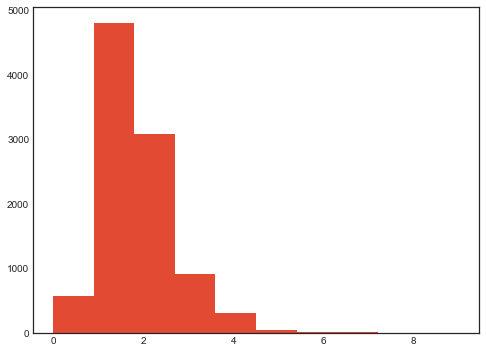

In [84]:
import datetime
tup = [[x for x in pd.date_range(start='2017-03-13 06:00',end='2017-03-26 23:00',freq=freq)],range(1,51)]
tups = list(it.product(*tup))
index = pd.MultiIndex.from_tuples((tups), names=['date_time', 'grid'])
test_set = pd.DataFrame(np.zeros(len(tups)),index=index,columns=['total'])
test_set = test_set.reset_index().set_index('date_time').sort_index()
test_set = test_set.between_time('9:00', '22:00')
weather = weather.resample(freq).fillna('nearest')
test_set = pd.merge(test_set,weather,left_index=True,right_index=True)
test_set = test_set.reset_index()
test_probs = rgbm.predict((build_features(test_set.drop(['total'],axis=1))))
submit = pd.DataFrame({'grid_id':test_set['grid'],'date_time':test_set['date_time'],'car_number':((test_probs))}).set_index(['date_time'])
car_grid_per_hour_aggr = pd.DataFrame()
for name,grp in submit.groupby('grid_id'):
    car_grid_per_hour = grp.sort_index()
    car_grid_per_hour['car_number'] = np.around(car_grid_per_hour.drop(['grid_id'],axis=1).resample('H').sum())
    car_grid_per_hour['grid_id'] = name
    car_grid_per_hour_aggr = pd.concat([car_grid_per_hour_aggr,car_grid_per_hour.dropna()],axis=0)

submitssion = pd.DataFrame()
for name,gp in car_grid_per_hour_aggr.reset_index().sort_values(by=['date_time','grid_id']).groupby('date_time'):
    submitssion = pd.concat([submitssion,gp])
    

submitssion['day'] = submitssion['date_time'].map(lambda x: x.strftime('%Y%m%d'))
submitssion['hour'] = submitssion['date_time'].map(lambda x: x.strftime('%H')).astype('int32')
submitssion['car_number'] = submitssion['car_number'].astype('int32')
column_titles = ['grid_id','day','hour','car_number']
submitssion = submitssion.reindex(columns=column_titles)
display(submitssion.describe())

plt.hist(submitssion['car_number'])
plt.show()

today = datetime.datetime.today().strftime("%Y%m%d%H%M")
submitssion.to_csv('submissions_%s_r.csv' % today,index=False)

#submit = pd.DataFrame({'grid_id':test_set['grid'],'day':test_set['date_time'].map(lambda x: x.strftime('%Y%m%d')),'hour':test_set['date_time'].map(lambda x: x.strftime('%H')),'car_number':np.around((test_probs))})
#column_titles = ['grid_id','day','hour','car_number']
#submit = submit.reindex(columns=column_titles)
##submit['hour'] = submit['hour'].map(lambda x:int(x)+1)
#submit['car_number'] = submit['car_number'].astype('int64')
#
#today = datetime.datetime.today().strftime("%Y%m%d%H%M")
#submit.to_csv('submissions_%s_r.csv' % today,index=False)
#
#display(submit.describe())
#plt.hist(submit['car_number'])
#plt.show()

In [319]:
tup = [[x for x in pd.date_range(start='2017-03-13 06:00',end='2017-03-26 23:00',freq='H')],range(1,51)]
tups = list(it.product(*tup))
index = pd.MultiIndex.from_tuples((tups), names=['date_time', 'grid'])
test_set = pd.DataFrame(np.zeros(len(tups)),index=index,columns=['total'])
test_set = test_set.reset_index().set_index('date_time').sort_index()
test_set = test_set.between_time('8:00', '22:00')
test_set.to_csv('./test.csv')